# 循环神经网络

目录

- 序列模型
- 文本预处理
- 语言模型和数据集
- 循环神经网络从零开始实现
- 循环神经网络的简洁实现

## 序列模型

使用正弦函数和一些可加性噪声来生成序列数据，时间步为$1, 2, \ldots, 1000$

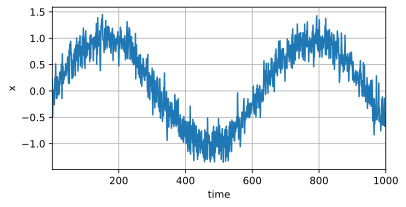

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对$y_t = x_t$和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$

In [4]:
tau = 4 # Markov 链长度
features = torch.zeros((T - tau, tau)) # x_t
for i in range(tau):
    features[:, i] = x[i: T - tau + i] # 顺延一个位置
labels = x[tau:].reshape((-1, 1)) # y_t

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

使用一个相当简单的架构训练模型：
一个拥有两个全连接层的多层感知机

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    """两个全连接层的多层感知机"""
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

训练模型

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)
# 损失值上升？训练瓶颈，或学习率偏大

epoch 1, loss: 0.075906
epoch 2, loss: 0.057385
epoch 3, loss: 0.055220
epoch 4, loss: 0.053874
epoch 5, loss: 0.054573


单步预测：模型预测下一个时间步。注意：600+4（n_train + tau）之后都是预测

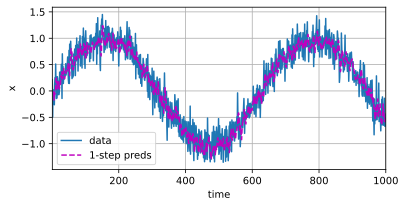

In [7]:
onestep_preds = net(features) # features[:, i] = x[i: T - tau + i]
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

多步预测：604之后预测很快衰减到常数，主要由于误差的累计

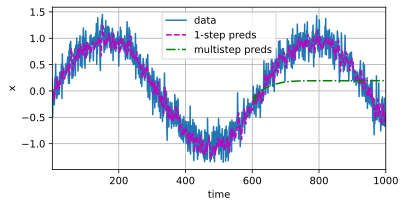

In [9]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net( # 当前预测基于之前的预测结果
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

更仔细地看一下$k$步预测

In [ ]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

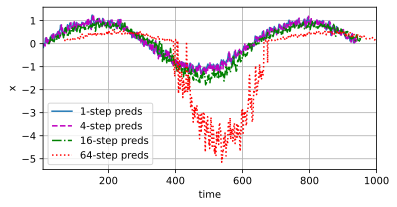

In [12]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

## 文本预处理



In [1]:
import collections
import re
from d2l import torch as d2l

将数据集读取到由多条文本行组成的列表中

In [2]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


文本序列拆分成词元列表：词元（token）是文本的基本单位

In [3]:
def tokenize(lines, token='word'):  
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


构建一个字典，通常也叫做*词表*（vocabulary），
用来将字符串类型的词元映射到从$0$开始的数字索引中

In [ ]:
class Vocab:  
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens) # 下页
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self): # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

In [4]:
def count_corpus(tokens):  
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

构建词表

In [5]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


将每一条文本行转换成一个数字索引列表

In [6]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


将所有功能打包到`load_corpus_time_machine`函数中

In [7]:
def load_corpus_time_machine(max_tokens=-1):  
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    # 使用字符（而不是单词）实现文本词元化
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 数据集中每个文本行不一定是一个句子或一个段落，所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 语言模型和数据集



In [2]:
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
# 每个文本行不一定是一个句子或一个段落，因此把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

频率高且无实意的词被称为*停用词*。画出的词频图：词频快速衰减

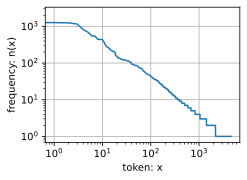

In [3]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

其他的词元组合，比如二元语法、三元语法等等，又会如何呢？

In [4]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

注意：在十个最频繁的词对中，有九个是由两个停用词组成的

In [5]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

对比结论：单词序列都遵循齐普夫定律；N元组的数量不大，说明语言中存在相当多的结构；很多N元组很少出现，使得拉普拉斯平滑非常不适合语言建模

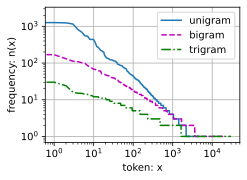

In [6]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

随机生成小批量数据的特征、标签以供读取。随机采样子序列

In [7]:
def seq_data_iter_random(corpus, batch_size, num_steps):  
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签（即当前预测）
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 随机抽样中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        """返回从pos位置开始的长度为num_steps的序列"""
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y) # 迭代器

生成一个从$0$到$34$的序列

In [8]:
my_seq = list(range(35)) # 每组10个，最多采样3组
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[29, 30, 31, 32, 33],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[30, 31, 32, 33, 34],
        [ 5,  6,  7,  8,  9]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
X:  tensor([[24, 25, 26, 27, 28],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[25, 26, 27, 28, 29],
        [20, 21, 22, 23, 24]])


保证两个相邻的小批量中的子序列在原始序列上也是相邻的

In [9]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y # 迭代器

读取每个小批量的子序列的特征`X`和标签`Y`

In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


将上面的两个采样函数包装到一个类中

In [11]:
class SeqDataLoader:  
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

最后，我们定义了一个函数`load_data_time_machine`，
它同时返回数据迭代器和词表

In [12]:
def load_data_time_machine(batch_size, num_steps,  
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## 循环神经网络从零开始实现



In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

独热编码：将词元编码为相互独立的单位向量

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab)) # 28个词元

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

小批量数据形状是二维张量：
（批量大小，时间步数）

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape # （时间步数，批量大小，词表大小）

torch.Size([5, 2, 28])

初始化循环神经网络模型的模型参数

In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

一个`init_rnn_state`函数在初始化时返回隐状态

In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    # （批量大小，隐藏单元数）
    return (torch.zeros((batch_size, num_hiddens), device=device), )

下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出

In [7]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        # 当元素在实数上均匀分布时，函数tanh的平均值为0
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

创建一个类来包装这些函数

In [8]:
class RNNModelScratch: 
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
# 输出：（时间步数x批量大小，词表大小）
# 隐状态：（批量大小，隐藏单元数）
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

预测函数：生成`prefix`之后的新字符。注意：训练样本仅是`prefix`，远不能达到优化目的

In [11]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # 预热期：不预测，只更新隐变量参数
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# 还未训练网络：预测结果相对随机
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller lfy lfy lf'

梯度裁剪
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

In [12]:
def grad_clipping(net, theta):  
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

定义一个函数在一个迭代周期内训练模型

In [13]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2) # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_() # state对于nn.GRU是单个张量
            else: # state对于nn.LSTM或对于从零开始实现的模型是张量元组
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1) # 已经调用了mean函数
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现，
也可以使用高级API来实现

In [14]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

现在，我们训练循环神经网络模型

困惑度 1.0, 67532.5 词元/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


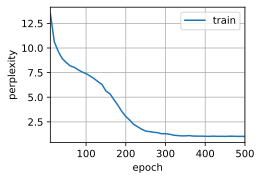

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

最后，让我们检查一下使用随机抽样方法的结果

困惑度 1.4, 67608.9 词元/秒 cuda:0
time travellerit s against reason said filbywan a gurently in th
traveller after the pauserequired for the proper assimilati


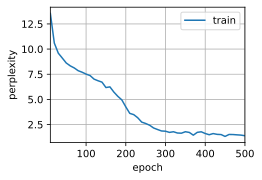

In [16]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

## 循环神经网络的简洁实现



In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

定义模型

In [2]:
num_hiddens = 256
# 注意，rnn_layer只包含隐藏的循环层
rnn_layer = nn.RNN(len(vocab), num_hiddens)

使用张量来初始化隐状态

In [3]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape # （隐藏层数，批量大小，隐藏单元数）

torch.Size([1, 32, 256])

通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出

In [4]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
# “输出”（Y）不涉及输出层的计算：它是指每个时间步的隐状态，
# 这些隐状态可以用作后续输出层的输入
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

我们为一个完整的循环神经网络模型定义了一个`RNNModel`类

In [5]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量H作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else: # nn.LSTM以元组(H,C)作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

基于随机权重初始化的模型进行预测：输出大量重复字符（类似之前人造数据`sin`函数的多步预测）

In [6]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerpcpppppppp'

使用高级API训练模型

perplexity 1.3, 293417.9 tokens/sec on cuda:0
time travellerif se gan ubsely fourth timethere is however a ten
traveller and wheth dimensisnal fis liger an andeterall hey


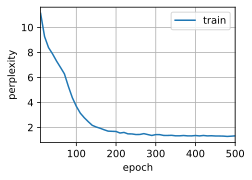

In [7]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)